# Quick start

Basic examples of data processing with helio framework.

### Content
* [Working with a single dataset](#Working-with-a-single-dataset)
* [Multiple datasets](#Multiple-datasets)
* [Batch processing of large dataset](#Batch-processing-of-large-dataset)

## Working with a single dataset

A typical problem everybody knows: there is large number of files that we want proccess in a similar way, e.g. resize all images and save them in a new format.

Let's start with indexing of files to be processed. Provide ``FilesIndex`` with a path to files and some reference name (e.g. ``img``) for the dataset:  

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sunpy.visualization.colormaps import color_tables as ct
sdoaia193 = ct.aia_color_table(193)

sys.path.append("..")
from helio import HelioBatch, FilesIndex, BatchSampler

index = FilesIndex(img='../../cospar/aia*.fits')
index.head()

,img
FilesIndex,
aia.lev1.193A_2014-07-15T22_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2014-07-15T22_00_06...
aia.lev1.193A_2014-10-02T10_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2014-10-02T10_00_06...
aia.lev1.193A_2015-01-04T06_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2015-01-04T06_00_06...
aia.lev1.193A_2015-01-21T00_00_08.61Z.image_lev1,../../cospar\aia.lev1.193A_2015-01-21T00_00_08...
aia.lev1.193A_2015-02-10T12_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2015-02-10T12_00_06...


Note that ``FilesIndex`` is inherited from ``pandas.DataFrame``, so you can do with ``index`` whatever you like to do with dataframes. E.g. slicing works as usual:

In [2]:
index.iloc[:3]

,img
FilesIndex,
aia.lev1.193A_2014-07-15T22_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2014-07-15T22_00_06...
aia.lev1.193A_2014-10-02T10_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2014-10-02T10_00_06...
aia.lev1.193A_2015-01-04T06_00_06.84Z.image_lev1,../../cospar\aia.lev1.193A_2015-01-04T06_00_06...


Now we initialize a batch that will contain indexed data:

In [3]:
batch = HelioBatch(index)

If the dataset is not too large, one can load it at once:

In [4]:
batch.load('img', unit=1)

To access loaded data use batch attribute ``img``:

In [5]:
batch.img[0].shape

(4096, 4096)

A list of available attributes:

In [6]:
batch.attributes

['img']

New attributes can be created as a result of data processing. E.g. we can resize images and save results in a new attribute:

In [7]:
batch.resize(src='img', dst='img_small', output_shape=(256, 256), preserve_range=True)

New attribute has been created:

In [8]:
batch.attributes

['img', 'img_small']

It contains resized data:

In [9]:
batch.img_small[0].shape

(256, 256)

Thus, `src` and `dst` specify source  and destination attributes. If `src` == `dst` or `dst`  is not specified, the method works inplace. To save outputs in a new place just set a destination different from source.

Now let's save reduced data in a pythonic-fiendly format ``npz``:

In [10]:
batch.dump(src='img_small', path='../../tmp/', format='npz')

To learn more about methods avaliable with `HelioBatch` see the [documentation]().

## Multiple datasets

Next typical example is when we have two or more sets of data. For example, one dataset is solar disk images, second one is a dataset of segmentation masks for active regions. We would like to merge the datasets to precess correrponding items. 

``FilesIndex`` allows merging in the same way as pandas dataframes. For example, we create  ``FilesIndex`` for each dataset and merge them by index (method `index_merge` is just a shortening for `x.merge(y, left_index=True, right_index=True)`):

In [11]:
images = FilesIndex(img='../../helio_cr_maps4/*.npz')
masks = FilesIndex(mask='../../helio_cr_maps_pred4/*.npz')
index = images.index_merge(masks)
index.head()

,img,mask
FilesIndex,,
2097,../../helio_cr_maps4\2097.npz,../../helio_cr_maps_pred4\2097.npz
2098,../../helio_cr_maps4\2098.npz,../../helio_cr_maps_pred4\2098.npz
2099,../../helio_cr_maps4\2099.npz,../../helio_cr_maps_pred4\2099.npz
2100,../../helio_cr_maps4\2100.npz,../../helio_cr_maps_pred4\2100.npz
2101,../../helio_cr_maps4\2101.npz,../../helio_cr_maps_pred4\2101.npz


At this point we can load images and corresponding masks into a batch:

In [12]:
batch = HelioBatch(index.iloc[:10]).load(('img', 'mask'))
batch.attributes

['img', 'mask']

Make a necessary preprocessing:

In [13]:
batch.resize(src='mask', output_shape=(360, 720), preserve_range=True)

Finally, images and masks can be plotted toghether with `batch.show`: 

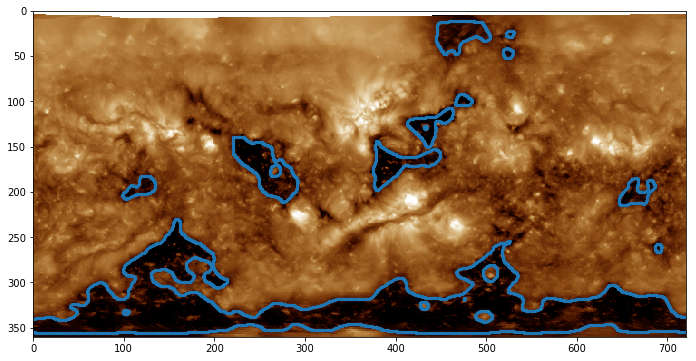

In [14]:
batch.show(8, image='img', mask='mask', figsize=(12, 6), cmap=sdoaia193, s=5)

## Batch processing of large dataset

The last topic is about large dataset processing. Large dataset means that we can not load is entirely at once and have to process it by subsets. In this case `BatchSampler` can help. It can sample random or subsequent sets of indices of given size. For example, the `BatchSampler(index, batch_size=10, n_epochs=1, shuffle=False, drop_last=False)` will iterate over indices with sets of size 10 until the dataset is exhausted. One can use it for single-pass processing. This is an example:

In [14]:
index = FilesIndex(img='../../cospar/aia*.fits')

batch_sampler = BatchSampler(index, batch_size=10, n_epochs=1, shuffle=False, drop_incomplete=False)

for ids in tqdm(batch_sampler):
    (HelioBatch(ids).load('img', unit=1)
     .resize(src='img', output_shape=(256, 256), preserve_range=True)
     .dump(src='img', path='./tmp/', format='npz'))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:44<00:00, 14.93s/it]


For models training pipelines one can set `shuffle = True` to sample random sets and iterate over dataset
multiple times setting larger `n_epochs`. In the latter case it is recommended to set ``drop_incomplete=True`` to avoid duplicated indices.

Done!